<a href="https://colab.research.google.com/github/gabrielmagno/piramide-etaria-vacina-covid19/blob/main/Pir%C3%A2mide_et%C3%A1ria_de_vacinados_contra_COVID_19_no_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pirâmide etária de vacinados contra COVID-19 no Brasil

Inspiração: 
- https://twitter.com/eliaskrainski/status/1384570962260238337
- https://twitter.com/eliaskrainski/status/1385056297322696709

## Parâmetros

In [ ]:
# Data de início e fim da análise. Por padrão a data de fim é configurada para o dia de hoje.
data_inicio <- as.Date("2021-01-17")
data_fim <- Sys.Date()

# Duração em segundos do video da animação
video_duracao <- 30 

## Instala "locale" do Brasil (opcional)

Para exibição de datas em português.

**NOTA**: executar a celula, e depois reiniciar o ambiente de execução

In [ ]:
system("sudo locale-gen pt_BR.utf8", intern=TRUE)
system("locale -a", intern=TRUE)

[1] "Generating locales (this might take a while)..."
[2] "  pt_BR.UTF-8... done"                          
[3] "Generation complete."

[1] "C"          "C.UTF-8"    "en_US.utf8" "POSIX"      "pt_BR.utf8"

In [ ]:
Sys.setlocale("LC_TIME", "pt_BR.utf8")

[1] "pt_BR.utf8"

## Limpa Arquivos de Exemplo

In [ ]:
system("rm -rf sample_data")

## Instala bibliotecas extra

In [ ]:
install.packages("shadowtext")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Carrega bibliotecas

In [ ]:
library(tidyverse)
library(lubridate)
library(httr)
library(jsonlite)
library(scales)
library(shadowtext)

## Dados PNAD (estimativa da população)

In [ ]:
system("wget -P dados https://ftp.ibge.gov.br/Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_continua/Trimestral/Microdados/2020/PNADC_042020.zip")

In [ ]:
system("unzip dados/PNADC_042020.zip -d dados")

In [ ]:
system("rm -f dados/PNADC_042020.zip")

In [ ]:
df_pnad <- read_fwf(
    "dados/PNADC_042020.txt",
    fwf_cols(
        V1027 = c(35, 49),
        V1028 = c(50, 64),
        V1029 = c(65, 73),
        V2007 = c(83, 83),
        V2009 = c(92, 94)
    ),
    col_types = cols(
        V1027 = col_double(),
        V1028 = col_double(),
        V1029 = col_integer(),
        V2009 = col_integer()
    )
) %>%
mutate(
    peso = V1028,
    sexo = if_else(V2007 == 1, "M", "F"),
    idade = V2009
) %>%
select(sexo, idade, peso)

df_pnad %>%
    head(10)

sexo,idade,peso
<chr>,<int>,<dbl>
F,39,126.9105
F,20,126.9105
F,16,126.9105
M,73,126.9105
F,59,126.9105
M,4,126.9105
F,37,126.9105
M,31,126.9105
F,44,126.9105


In [ ]:
df_pnad_piramide <- df_pnad %>%
    count(sexo, idade, wt = peso) %>%
    mutate(n = round(n))

df_pnad_piramide %>%
    head(5)

sexo,idade,n
<chr>,<int>,<dbl>
F,0,863138
F,1,1077444
F,2,1216507
F,3,1135490
F,4,1228301


## Coletar dados de vacinação

In [ ]:
retrieve_n_vacinados <- function(target_date, target_dose=1) {
    query_count_idade_sexo <- sprintf('
        {
            "size": 0,
            "query": { 
                "bool": { 
                    "must": [
                        { "match_phrase": {"vacina_descricao_dose": "    %dª Dose"}},
                        { "range" : {"vacina_dataAplicacao": {
                            "lte" : "%s"
                        }}}
                    ]
                }
            },
            "aggs": {
                "contagem_idade": {
                    "terms": {
                        "field": "paciente_idade",
                        "size": 1000
                    },
                    "aggs": {
                        "contagem_sexo": {
                            "terms": {
                                "field": "paciente_enumSexoBiologico",
                                "size": 1000
                            }
                        }
                    }
                }
            }
        }',
        target_dose,
        target_date
    )

    req <- POST(
        "https://imunizacao-es.saude.gov.br/_search",
        content_type("application/json"),
        authenticate("imunizacao_public", "qlto5t&7r_@+#Tlstigi"),
        body = query_count_idade_sexo
    )

    res <- content(req, "parsed")

    buckets <- res$aggregation$contagem_idade$buckets

    df_counts <- tibble()

    for (i in 1:length(buckets)) {
        df_counts <- df_counts %>%
            bind_rows(
                lapply(buckets[[i]]$contagem_sexo$buckets, as.data.frame) %>% 
                        bind_rows %>%
                        rename(
                            n_vacinados = doc_count,
                            sexo = key
                        ) %>%
                        mutate(
                            data = target_date,
                            dose = target_dose,
                            idade = buckets[[i]]$key
                        ) %>%
                        select(data, dose, idade, sexo, n_vacinados) %>%
                        arrange(idade, sexo)
            )
    }

    return(df_counts)
}

In [ ]:
target_all_dates <- as.list(seq(data_inicio, data_fim, by = 1, units = "days"))
print(length(target_all_dates))
target_all_dates

[1] 100


[[1]]
[1] "2021-01-17"

[[2]]
[1] "2021-01-18"

[[3]]
[1] "2021-01-19"

[[4]]
[1] "2021-01-20"

[[5]]
[1] "2021-01-21"

[[6]]
[1] "2021-01-22"

[[7]]
[1] "2021-01-23"

[[8]]
[1] "2021-01-24"

[[9]]
[1] "2021-01-25"

[[10]]
[1] "2021-01-26"

[[11]]
[1] "2021-01-27"

[[12]]
[1] "2021-01-28"

[[13]]
[1] "2021-01-29"

[[14]]
[1] "2021-01-30"

[[15]]
[1] "2021-01-31"

[[16]]
[1] "2021-02-01"

[[17]]
[1] "2021-02-02"

[[18]]
[1] "2021-02-03"

[[19]]
[1] "2021-02-04"

[[20]]
[1] "2021-02-05"

[[21]]
[1] "2021-02-06"

[[22]]
[1] "2021-02-07"

[[23]]
[1] "2021-02-08"

[[24]]
[1] "2021-02-09"

[[25]]
[1] "2021-02-10"

[[26]]
[1] "2021-02-11"

[[27]]
[1] "2021-02-12"

[[28]]
[1] "2021-02-13"

[[29]]
[1] "2021-02-14"

[[30]]
[1] "2021-02-15"

[[31]]
[1] "2021-02-16"

[[32]]
[1] "2021-02-17"

[[33]]
[1] "2021-02-18"

[[34]]
[1] "2021-02-19"

[[35]]
[1] "2021-02-20"

[[36]]
[1] "2021-02-21"

[[37]]
[1] "2021-02-22"

[[38]]
[1] "2021-02-23"

[[39]]
[1] "2021-02-24"

[[40]]
[1] "2021-02-25"

[[41]]
[1] "2021-02-26"

[[42]]
[1] "2021-02-27"

[[43]]
[1] "2021-02-28"

[[44]]
[1] "2021-03-01"

[[45]]
[1] "2021-03-02"

[[46]]
[1] "2021-03-03"

[[47]]
[1] "2021-03-04"

[[48]]
[1] "2021-03-05"

[[49]]
[1] "2021-03-06"

[[50]]
[1] "2021-03-07"

[[51]]
[1] "2021-03-08"

[[52]]
[1] "2021-03-09"

[[53]]
[1] "2021-03-10"

[[54]]
[1] "2021-03-11"

[[55]]
[1] "2021-03-12"

[[56]]
[1] "2021-03-13"

[[57]]
[1] "2021-03-14"

[[58]]
[1] "2021-03-15"

[[59]]
[1] "2021-03-16"

[[60]]
[1] "2021-03-17"

[[61]]
[1] "2021-03-18"

[[62]]
[1] "2021-03-19"

[[63]]
[1] "2021-03-20"

[[64]]
[1] "2021-03-21"

[[65]]
[1] "2021-03-22"

[[66]]
[1] "2021-03-23"

[[67]]
[1] "2021-03-24"

[[68]]
[1] "2021-03-25"

[[69]]
[1] "2021-03-26"

[[70]]
[1] "2021-03-27"

[[71]]
[1] "2021-03-28"

[[72]]
[1] "2021-03-29"

[[73]]
[1] "2021-03-30"

[[74]]
[1] "2021-03-31"

[[75]]
[1] "2021-04-01"

[[76]]
[1] "2021-04-02"

[[77]]
[1] "2021-04-03"

[[78]]
[1] "2021-04-04"

[[79]]
[1] "2021-04-05"

[[80]]
[1] "2021-04-06"

[[81]]
[1] "2021-04-07"

[[82]]
[1] "2021-04-08"

[[83]]
[1] "2021-04-09"

[[84]]
[1] "2021-04-10"

[[85]]
[1] "2021-04-11"

[[86]]
[1] "2021-04-12"

[[87]]
[1] "2021-04-13"

[[88]]
[1] "2021-04-14"

[[89]]
[1] "2021-04-15"

[[90]]
[1] "2021-04-16"

[[91]]
[1] "2021-04-17"

[[92]]
[1] "2021-04-18"

[[93]]
[1] "2021-04-19"

[[94]]
[1] "2021-04-20"

[[95]]
[1] "2021-04-21"

[[96]]
[1] "2021-04-22"

[[97]]
[1] "2021-04-23"

[[98]]
[1] "2021-04-24"

[[99]]
[1] "2021-04-25"

[[100]]
[1] "2021-04-26"

In [ ]:
df_vacina_piramide_datas <- tibble()

for (target_date in target_all_dates) {
    print(target_date)
    df_new_dose_1 <- retrieve_n_vacinados(target_date, 1)
    df_new_dose_2 <- retrieve_n_vacinados(target_date, 2)
    df_vacina_piramide_datas <- df_vacina_piramide_datas %>%
        bind_rows(df_new_dose_1) %>%
        bind_rows(df_new_dose_2)
}

df_vacina_piramide_datas %>%
    count(data) %>%
    arrange(data)

[1] "2021-01-17"
[1] "2021-01-18"
[1] "2021-01-19"
[1] "2021-01-20"
[1] "2021-01-21"
[1] "2021-01-22"
[1] "2021-01-23"
[1] "2021-01-24"
[1] "2021-01-25"
[1] "2021-01-26"
[1] "2021-01-27"
[1] "2021-01-28"
[1] "2021-01-29"
[1] "2021-01-30"
[1] "2021-01-31"
[1] "2021-02-01"
[1] "2021-02-02"
[1] "2021-02-03"
[1] "2021-02-04"
[1] "2021-02-05"
[1] "2021-02-06"
[1] "2021-02-07"
[1] "2021-02-08"
[1] "2021-02-09"
[1] "2021-02-10"
[1] "2021-02-11"
[1] "2021-02-12"
[1] "2021-02-13"
[1] "2021-02-14"
[1] "2021-02-15"
[1] "2021-02-16"
[1] "2021-02-17"
[1] "2021-02-18"
[1] "2021-02-19"
[1] "2021-02-20"
[1] "2021-02-21"
[1] "2021-02-22"
[1] "2021-02-23"
[1] "2021-02-24"
[1] "2021-02-25"
[1] "2021-02-26"
[1] "2021-02-27"
[1] "2021-02-28"
[1] "2021-03-01"
[1] "2021-03-02"
[1] "2021-03-03"
[1] "2021-03-04"
[1] "2021-03-05"
[1] "2021-03-06"
[1] "2021-03-07"
[1] "2021-03-08"
[1] "2021-03-09"
[1] "2021-03-10"
[1] "2021-03-11"
[1] "2021-03-12"
[1] "2021-03-13"
[1] "2021-03-14"
[1] "2021-03-15"
[1] "2021-03-1

data,n
<date>,<int>
2021-01-17,230
2021-01-18,270
2021-01-19,317
2021-01-20,368
2021-01-21,393
2021-01-22,400
2021-01-23,402
2021-01-24,403
2021-01-25,404


## Agregar dados de população e vacina

In [ ]:
df_piramide_datas <- tibble()

for (target_date in target_all_dates) {

    df_piramide <- bind_rows(
        df_pnad_piramide %>%
            mutate(tipo = "pop") %>%
            select(tipo, sexo, idade, n),
        df_vacina_piramide_datas %>%
            filter(data == target_date) %>%
            mutate(
                tipo = sprintf("dose_%d", dose),
                n = n_vacinados
            ) %>%
            select(tipo, sexo, idade, n)
    ) %>%
    filter(idade <= max(df_pnad_piramide$idade)) %>%
    filter(sexo != "I") %>%
    mutate(data = target_date) %>%
    select(data, everything())


    df_piramide_datas <- df_piramide_datas %>%
        bind_rows(df_piramide)
}

df_piramide_datas %>%
    head(5)

data,tipo,sexo,idade,n
<date>,<chr>,<chr>,<int>,<dbl>
2021-01-17,pop,F,0,863138
2021-01-17,pop,F,1,1077444
2021-01-17,pop,F,2,1216507
2021-01-17,pop,F,3,1135490
2021-01-17,pop,F,4,1228301


In [ ]:
df_piramide_datas_diff <- df_piramide_datas %>%
    complete(data, idade, sexo, tipo, fill=list(n=0)) %>%
    pivot_wider(names_from = tipo, values_from = n) %>%
    rowwise() %>%
    mutate(
        pop = max(pop - dose_1, 0),
        dose_1 = max(dose_1 - dose_2, 0)
    ) %>%
    ungroup() %>%
    pivot_longer(-c(data, idade, sexo), names_to = "tipo", values_to = "n_pessoas")

df_piramide_datas_diff %>%
    head(5)

data,idade,sexo,tipo,n_pessoas
<date>,<int>,<chr>,<chr>,<dbl>
2021-01-17,0,F,dose_1,7
2021-01-17,0,F,dose_2,0
2021-01-17,0,F,pop,863131
2021-01-17,0,M,dose_1,1
2021-01-17,0,M,dose_2,0


In [ ]:
my_format_num <- function(x) {
    case_when(
        abs(x) >= 999949 ~ sprintf("%.1f milhões", abs(x/1E6)), 
        abs(x) >= 1E3 ~ sprintf("%.1f mil", abs(x/1E3)),
        TRUE     ~ as.character(x)
    )
}

df_legend_labels_datas <- df_piramide_datas %>%
    count(data, tipo, sexo, wt = n) %>%
    mutate(
        sexo_pretty = if_else(sexo == "F", "Mulheres", "Homens"),
        tipo_pretty = case_when(
            tipo == "dose_1" ~ "Dose 1",
            tipo == "dose_2" ~ "Dose 2",
            TRUE             ~ "Pop. est. Abr/2020"
        ),
        tipo_pretty = fct_relevel(tipo_pretty, "Pop. est. Abr/2020"),
        label = sprintf(
            "%s - %s: %s",
            sexo_pretty,
            tipo_pretty,
            my_format_num(n)
        )
    ) %>%
    arrange(data, sexo, tipo_pretty) %>%
    mutate(
        label = fct_inorder(label)
    )
    
df_legend_labels_datas %>%
    head(10)

data,tipo,sexo,n,sexo_pretty,tipo_pretty,label
<date>,<chr>,<chr>,<dbl>,<chr>,<fct>,<fct>
2021-01-17,pop,F,111109506,Mulheres,Pop. est. Abr/2020,Mulheres - Pop. est. Abr/2020: 111.1 milhões
2021-01-17,dose_1,F,437,Mulheres,Dose 1,Mulheres - Dose 1: 437
2021-01-17,dose_2,F,81,Mulheres,Dose 2,Mulheres - Dose 2: 81
2021-01-17,pop,M,100542864,Homens,Pop. est. Abr/2020,Homens - Pop. est. Abr/2020: 100.5 milhões
2021-01-17,dose_1,M,203,Homens,Dose 1,Homens - Dose 1: 203
2021-01-17,dose_2,M,45,Homens,Dose 2,Homens - Dose 2: 45
2021-01-18,pop,F,111109506,Mulheres,Pop. est. Abr/2020,Mulheres - Pop. est. Abr/2020: 111.1 milhões
2021-01-18,dose_1,F,2139,Mulheres,Dose 1,Mulheres - Dose 1: 2.1 mil
2021-01-18,dose_2,F,147,Mulheres,Dose 2,Mulheres - Dose 2: 147


In [ ]:
df_piramide_datas_plot <- df_piramide_datas_diff %>%
    left_join(df_legend_labels_datas, by = c("data", "tipo", "sexo")) %>%
    arrange(data, idade, label) %>%
    mutate(label = fct_inorder(label))

df_piramide_datas_plot %>%
    head(5)

data,idade,sexo,tipo,n_pessoas,n,sexo_pretty,tipo_pretty,label
<date>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>
2021-01-17,0,F,pop,863131,111109506,Mulheres,Pop. est. Abr/2020,Mulheres - Pop. est. Abr/2020: 111.1 milhões
2021-01-17,0,F,dose_1,7,437,Mulheres,Dose 1,Mulheres - Dose 1: 437
2021-01-17,0,F,dose_2,0,81,Mulheres,Dose 2,Mulheres - Dose 2: 81
2021-01-17,0,M,pop,894098,100542864,Homens,Pop. est. Abr/2020,Homens - Pop. est. Abr/2020: 100.5 milhões
2021-01-17,0,M,dose_1,1,203,Homens,Dose 1,Homens - Dose 1: 203


## Gráfico da Pirámide Etária

In [ ]:
plot_piramide <- function(target_date) {
    df_piramide_datas_plot %>%
        filter(data == target_date) %>%
        arrange(data, idade, sexo, tipo_pretty) %>%
        mutate(label = fct_inorder(as.character(label))) %>%
        mutate(
            n_pessoas = if_else(sexo=="F", -n_pessoas, n_pessoas),
        ) %>%
        ggplot(aes(x = idade, y = n_pessoas, fill = label)) +
            geom_col(width=1) + 
            geom_shadowtext(
                data=tibble(x=seq(10, 100, 10)), 
                aes(x=x, label=x), 
                y=0,
                inherit.aes = FALSE
            ) +
            coord_flip() + 
            scale_x_continuous(
                breaks = breaks_width(10, offset = 0),
                expand = expansion(mult = c(0.01, 0))
            ) +
            scale_y_continuous(
                labels = function(x) case_when(
                    abs(x) >= 1E6 ~ sprintf("%.1f milhão", abs(x/1E6)), 
                    abs(x) > 0    ~ sprintf("%d mil", abs(x/1E3)),
                    TRUE          ~ "0"
                ), 
                breaks = breaks_extended(n = 10)
            ) +
            scale_fill_manual(
                "",
                values = c(
                    "#F4A582",
                    "#D6604D",
                    "#B2182B",
                    "#92C5DE",
                    "#4393C3",
                    "#2166AC"
                ),
                guide = guide_legend(ncol = 2)
            ) +
            theme_bw() +
            theme(
                legend.position = c(.55, .92),
                legend.background = element_rect(fill="transparent"),
                legend.text = element_text(margin=margin(0, 50, 0, 0, "pt")),
                axis.text.y = element_blank(),
                axis.ticks.y = element_blank(),
                axis.line.y = element_blank()
            ) +
            labs(
                title = "Pirâmide etária de vacinados contra COVID-19 no Brasil",
                subtitle = sprintf("Vacinados até: %s", format(target_date, "%d %b %Y")),
                x = "Idade",
                y = "Número de Pessoas",
                caption = sprintf(
                    "Fonte (população): https://www.ibge.gov.br/estatisticas/sociais/trabalho/17270-pnad-continua.html\nFonte (vacinação): https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao\nGráfico por Gabriel Magno (https://gmagno.net), inspirado no @eliaskrainski - Gerado em %s",
                    format(Sys.Date(), "%d/%m/%Y")
                )
            )
}

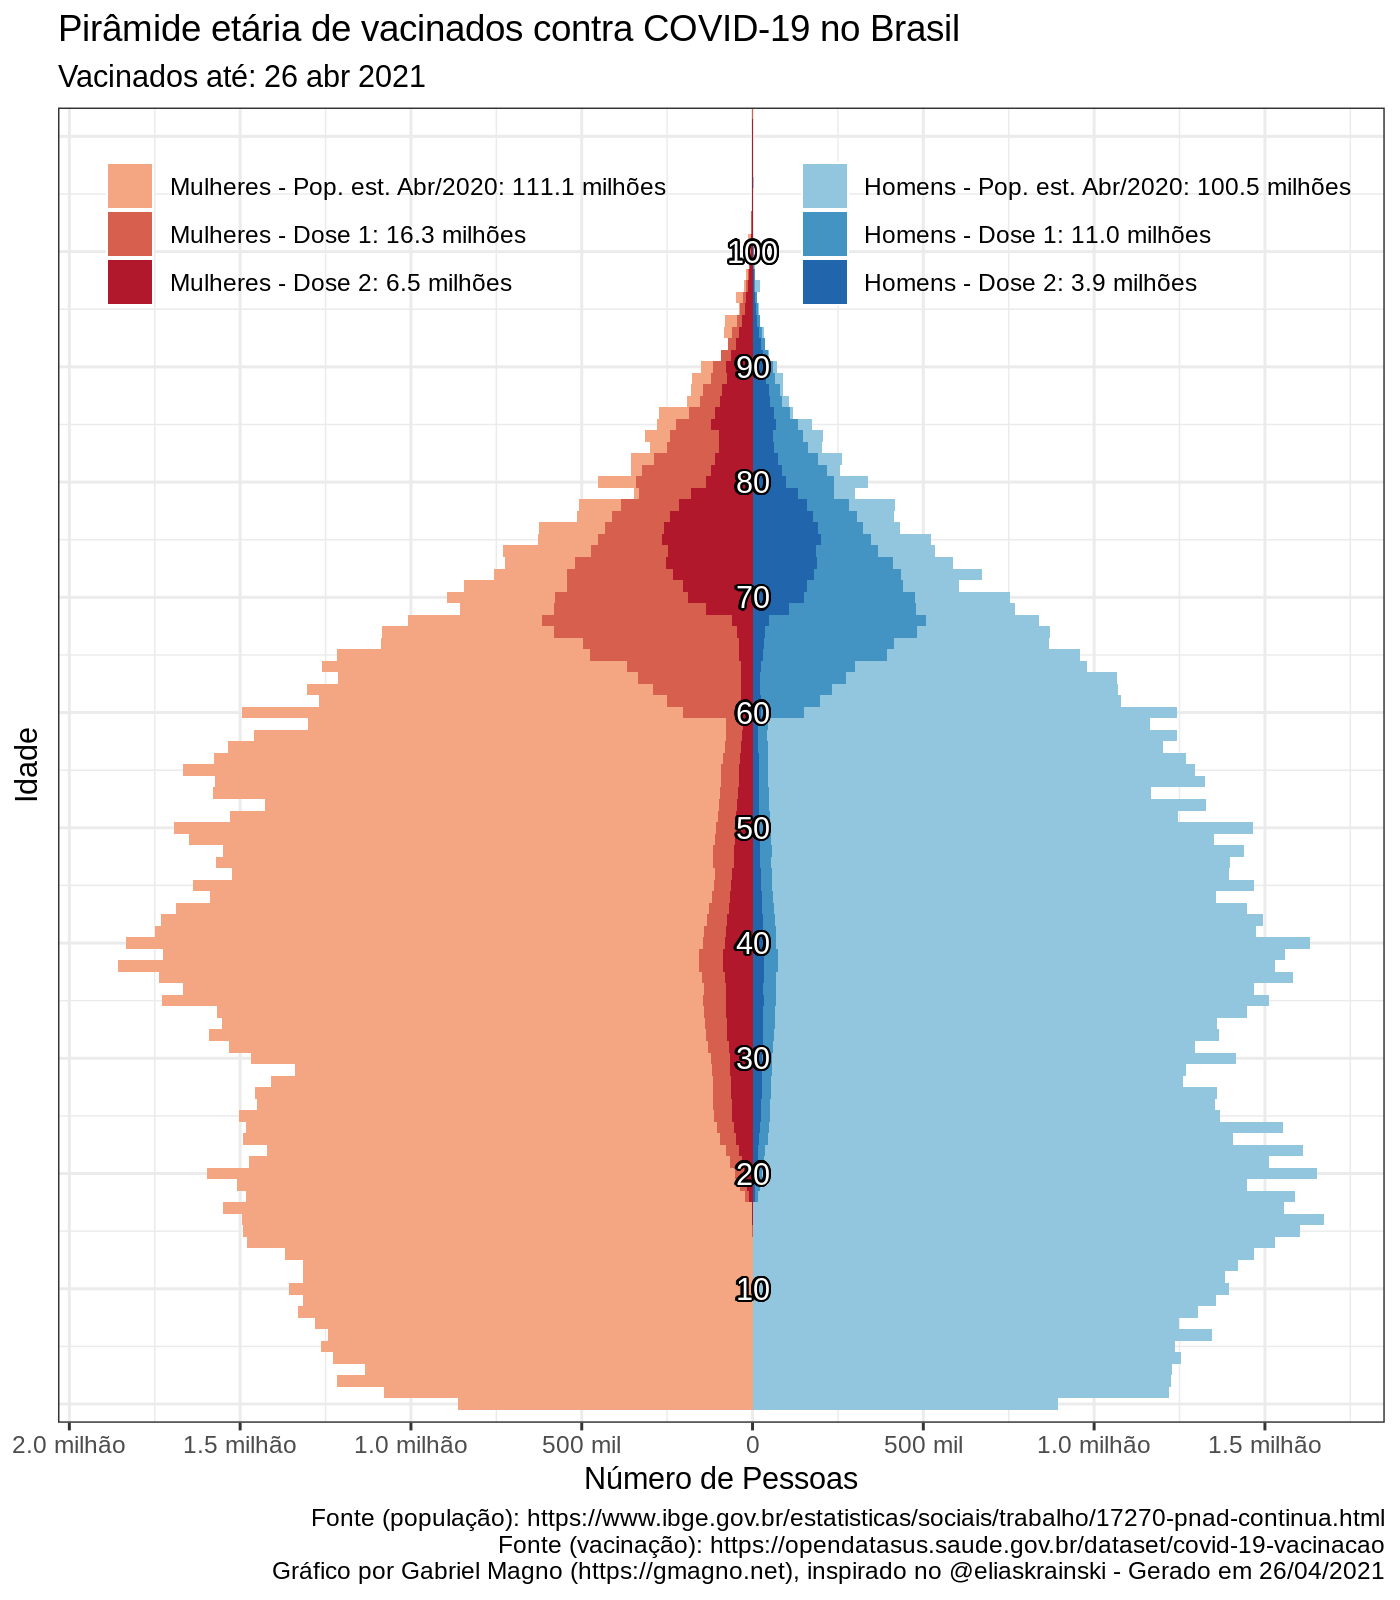

In [ ]:
options(repr.plot.unit="px", repr.plot.res=200, repr.plot.width=7, repr.plot.height=8)
plot_piramide(data_fim)

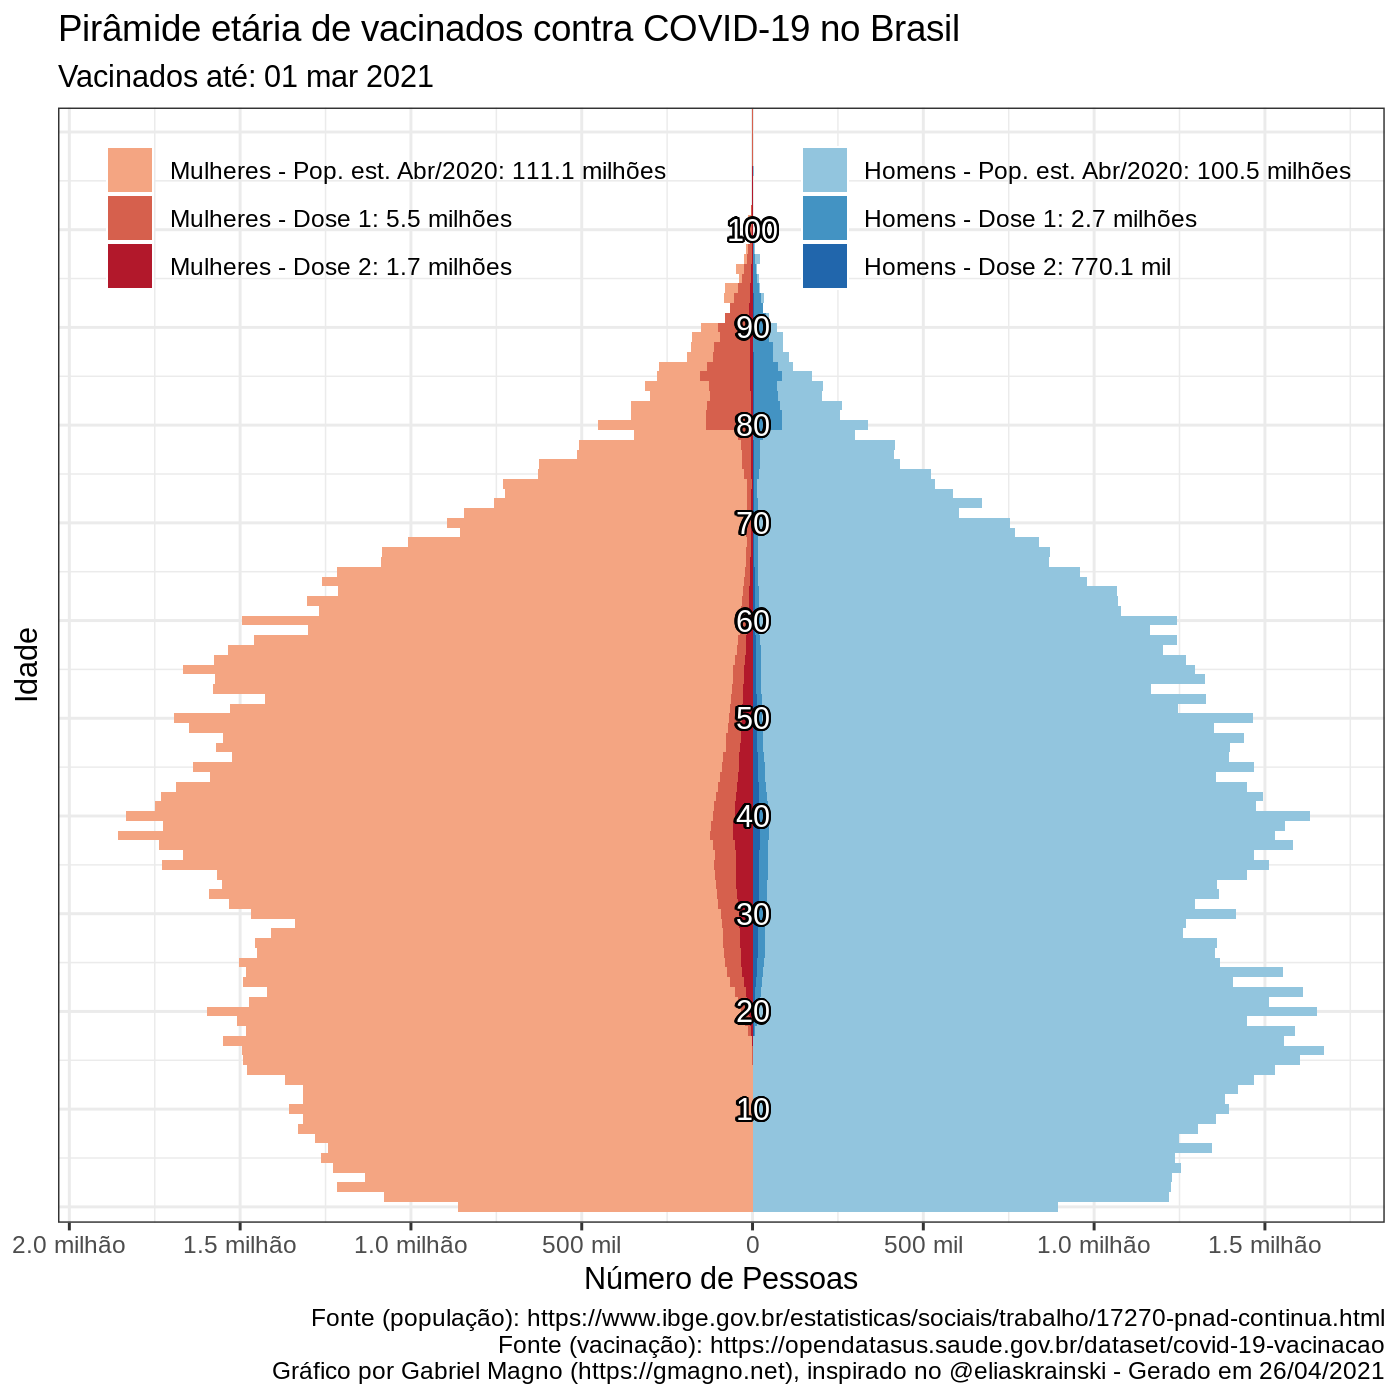

In [ ]:
options(repr.plot.unit="px", repr.plot.res=200, repr.plot.width=7, repr.plot.height=7)
plot_piramide(ymd("2021-03-01"))

## Animação da evolução temporal da pirâmide etária

### Plota gráficos para lista de datas

In [ ]:
dir.create("plots")
for (i in 1:length(target_all_dates)) {
    target_date <- target_all_dates[[i]]
    outfile_name <- sprintf("plots/piramide-%s.png", format(target_date, "%Y_%m_%d"))
    p <- plot_piramide(target_date)
    ggsave(outfile_name, plot=p, dpi=200, width=7, height=8)
}

### Cria video da animação

In [ ]:
video_n_frames <- length(target_all_dates)
video_fps <- video_n_frames / video_duracao
video_fps

[1] 3.333333

In [ ]:
video_outfile <- sprintf(
    "videos/piramide_temporal-%s-%s.mp4",
    format(data_inicio, "%Y_%m_%d"),
    format(data_fim, "%Y_%m_%d")
)
video_outfile

[1] "videos/piramide_temporal-2021_01_17-2021_04_26.mp4"

In [ ]:
dir.create("videos")

system2(
    "ffmpeg",
    c(
        "-pattern_type", "glob",
        paste0("-r ", video_fps),
        "-i", "'plots/piramide-*.png'",
        "-y",
        "-hide_banner",
        "-r", "24",
        "-vf", "format=yuv420p",
        video_outfile
    )
)